# Baseline Random Forest Training on CRPWarner Dataset

## Import Libraries

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
import time
import json
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier

## Const

In [12]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [13]:
with open(os.path.join(DATA_PATH, 'feature-opcode-n-gram_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels-opcode-n-gram.json')) as f:
    labels = json.load(f)

In [14]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train-opcode-n-gram.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test-opcode-n-gram.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

## Traditional Machine Learning Models

In [15]:
models = {
    "Logistic Regression": MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    "Random Forest": MultiOutputClassifier(RandomForestClassifier()),
    "Gradient Boosting": MultiOutputClassifier(GradientBoostingClassifier()),
    "AdaBoost": MultiOutputClassifier(AdaBoostClassifier()),
    "SVM (Linear)": MultiOutputClassifier(SVC(kernel="linear")),
    "KNN": MultiOutputClassifier(KNeighborsClassifier()),
    "Naive Bayes": MultiOutputClassifier(GaussianNB()),
    "MLP Classifier": MultiOutputClassifier(MLPClassifier(max_iter=300)),
    "XGBoost": MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    "LightGBM": MultiOutputClassifier(LGBMClassifier()),
    "DecisionTree": MultiOutputClassifier(DecisionTreeClassifier())
}

In [16]:
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),  # change to 'macro' if multi-class
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1-Score": f1_score(y_test, y_pred, average="macro"),
        "Training Time": round(end - start, 3)
    })

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9007
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254545 -> initscore=-1.074515
[LightGBM] [Info] Start training from score -1.074515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

### Result

In [17]:
df = pd.DataFrame(results)
df.sort_values(by="F1-Score", ascending=False, inplace=True)
df

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Time
8,XGBoost,0.428571,0.755556,0.425926,0.526263,20.293
2,Gradient Boosting,0.500000,0.833333,0.388889,0.520513,5.744
9,LightGBM,0.285714,0.607143,0.425926,0.500000,0.459
5,KNN,0.214286,0.444444,0.425926,0.422222,0.144
6,Naive Bayes,0.500000,0.666667,0.296296,0.404762,0.192
1,Random Forest,0.428571,0.611111,0.296296,0.388889,0.547
10,DecisionTree,0.500000,0.466667,0.314815,0.372294,0.219
0,Logistic Regression,0.357143,0.500000,0.296296,0.370370,3.964
4,SVM (Linear),0.357143,0.500000,0.296296,0.370370,0.216
7,MLP Classifier,0.357143,0.500000,0.240741,0.321429,10.438


### Tuning

In [20]:
# 1. Optuna objective with AdaBoost inside MultiOutputClassifier
def objective(trial):
    model = MultiOutputClassifier(XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 10, 1000),
        max_depth=trial.suggest_int("max_depth", 1, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.0000001, 1.0, log=True),
        subsample=trial.suggest_float("subsample", 0.1, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.1, 1.0),
        gamma=trial.suggest_float("gamma", 0, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 10.0),
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
    ))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average="macro", zero_division=0)

# 2. Optimize AdaBoost
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 3. Build base classifiers
model = MultiOutputClassifier(XGBClassifier(**study.best_params, random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Tuned XGBClassifier (MultiOutput):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))


[I 2025-07-11 15:40:21,395] A new study created in memory with name: no-name-15a720d9-70b3-4a50-bb58-23385f3c2e44
[I 2025-07-11 15:41:36,474] Trial 0 finished with value: 0.19047619047619047 and parameters: {'n_estimators': 473, 'max_depth': 9, 'learning_rate': 0.011726041161503362, 'subsample': 0.957880615883327, 'colsample_bytree': 0.9440304270806165, 'gamma': 3.2088062594611944, 'reg_alpha': 0.9675683117131462, 'reg_lambda': 5.739353997869854}. Best is trial 0 with value: 0.19047619047619047.
[I 2025-07-11 15:42:44,647] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 448, 'max_depth': 8, 'learning_rate': 0.000387856230251917, 'subsample': 0.33448199665102757, 'colsample_bytree': 0.4074011433157676, 'gamma': 1.8326977651520282, 'reg_alpha': 3.971388546599961, 'reg_lambda': 4.17054119756182}. Best is trial 0 with value: 0.19047619047619047.
[I 2025-07-11 15:44:52,211] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 997, 'max_depth': 2, 'learning_rat

Tuned XGBClassifier (MultiOutput):
Accuracy: 0.42857142857142855
Precision: 0.8055555555555555
Recall: 0.4259259259259259
F1 Score: 0.5444444444444444


In [21]:
joblib.dump(model, os.path.join(MODEL_PATH, f'best_xgboost_model_on_crpwarner_opcode_n-gram.pkl'))

['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_xgboost_model_on_crpwarner_opcode_n-gram.pkl']

### K-Fold (K=3)

In [22]:
NUM_FOLDS = 3
results = []
best_model = MultiOutputClassifier(XGBClassifier(**study.best_params, random_state=42))
best_f1 = 0
best_fold = 0

In [23]:
for fold in range(NUM_FOLDS):
    print(f"=========== Fold-{fold} ===========")
    train_path = os.path.join(DATA_PATH, f'train_fold_{fold}-opcode-n-gram.csv')
    val_path = os.path.join(DATA_PATH, f'val_fold_{fold}-opcode-n-gram.csv')

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)

    X_train = train_df[feature_list]
    y_train = train_df[labels]

    X_val = val_df[feature_list]
    y_val = val_df[labels]

    # Train model
    model = MultiOutputClassifier(XGBClassifier(**study.best_params, random_state=42))
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    results.append({'fold': fold, 'accuracy': acc, 'report': report})
    print(f"Accuracy: {acc}")
    print("Precision:", precision_score(y_val, y_pred, average="macro", zero_division=0))
    print("Recall:", recall_score(y_val, y_pred, average="macro", zero_division=0))
    print("F1 Score:", f1)

    if best_f1 < f1:
        best_model = model
        best_fold = fold
## Step 6: Average Performance Summary
print("\n===== Overall Summary =====")
avg_acc = sum([r['accuracy'] for r in results]) / NUM_FOLDS
print(f"Average Accuracy: {avg_acc:.4f}")

# Save model
joblib.dump(best_model, os.path.join(MODEL_PATH, f'best_xgboost_model_on_crpwarner_opcode_n_gram_from_fold{best_fold}.pkl'))

=========== Fold-0 ===========
Accuracy: 0.5217391304347826
Precision: 0.4484848484848485
Recall: 0.3904761904761904
F1 Score: 0.41269841269841273
=========== Fold-1 ===========
Accuracy: 0.5652173913043478
Precision: 0.375
Recall: 0.5
F1 Score: 0.4230769230769231
=========== Fold-2 ===========
Accuracy: 0.6521739130434783
Precision: 0.5185185185185185
Recall: 0.4047619047619048
F1 Score: 0.4305555555555555

===== Overall Summary =====
Average Accuracy: 0.5797


['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_xgboost_model_on_crpwarner_opcode_n_gram_from_fold2.pkl']

## CNN

### Structure

In [24]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

opcode_dim = len(feature_list)

def MLClassifier():
    return Sequential([
        Dense(512, input_dim=opcode_dim, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

model = MLClassifier()
model.compile(
    loss='binary_crossentropy',  # important for multi-label!
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', 'AUC']
)


2025-07-11 16:32:00.146436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_file = os.path.join(MODEL_PATH, "cnn_best_model_on_crpwarner_opcode_n_gram.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.4797 - accuracy: 0.2391 - loss: 2.2225

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - AUC: 0.4797 - accuracy: 0.2391 - loss: 2.2225 - val_AUC: 0.3935 - val_accuracy: 0.1429 - val_loss: 4.3075 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - AUC: 0.6368 - accuracy: 0.2826 - loss: 2.0788 - val_AUC: 0.3970 - val_accuracy: 0.1429 - val_loss: 4.3338 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.6703 - accuracy: 0.3696 - loss: 1.9806

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - AUC: 0.6703 - accuracy: 0.3696 - loss: 1.9806 - val_AUC: 0.3958 - val_accuracy: 0.1429 - val_loss: 3.8304 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - AUC: 0.7222 - accuracy: 0.3696 - loss: 1.8692 - val_AUC: 0.3889 - val_accuracy: 0.1429 - val_loss: 3.8490 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.7606 - accuracy: 0.5000 - loss: 1.7865

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - AUC: 0.7606 - accuracy: 0.5000 - loss: 1.7865 - val_AUC: 0.4051 - val_accuracy: 0.1429 - val_loss: 3.5774 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.7450 - accuracy: 0.3696 - loss: 1.7029

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - AUC: 0.7450 - accuracy: 0.3696 - loss: 1.7029 - val_AUC: 0.4051 - val_accuracy: 0.1429 - val_loss: 3.3522 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.8068 - accuracy: 0.4130 - loss: 1.6179

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - AUC: 0.8068 - accuracy: 0.4130 - loss: 1.6179 - val_AUC: 0.4039 - val_accuracy: 0.1429 - val_loss: 3.1444 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.8711 - accuracy: 0.5000 - loss: 1.5155

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - AUC: 0.8711 - accuracy: 0.5000 - loss: 1.5155 - val_AUC: 0.3935 - val_accuracy: 0.1429 - val_loss: 3.0610 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.9013 - accuracy: 0.4783 - loss: 1.4307

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - AUC: 0.9013 - accuracy: 0.4783 - loss: 1.4307 - val_AUC: 0.3831 - val_accuracy: 0.1429 - val_loss: 2.9878 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.9016 - accuracy: 0.5000 - loss: 1.3941

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - AUC: 0.9016 - accuracy: 0.5000 - loss: 1.3941 - val_AUC: 0.3796 - val_accuracy: 0.1429 - val_loss: 2.8483 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.8837 - accuracy: 0.5435 - loss: 1.3651

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - AUC: 0.8837 - accuracy: 0.5435 - loss: 1.3651 - val_AUC: 0.4028 - val_accuracy: 0.1429 - val_loss: 2.6511 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.9139 - accuracy: 0.5217 - loss: 1.3080

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - AUC: 0.9139 - accuracy: 0.5217 - loss: 1.3080 - val_AUC: 0.4387 - val_accuracy: 0.1429 - val_loss: 2.4643 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.9236 - accuracy: 0.5217 - loss: 1.2603

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - AUC: 0.9236 - accuracy: 0.5217 - loss: 1.2603 - val_AUC: 0.4444 - val_accuracy: 0.0714 - val_loss: 2.3113 - learning_rate: 0.0010
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.8875 - accuracy: 0.5000 - loss: 1.2514

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - AUC: 0.8875 - accuracy: 0.5000 - loss: 1.2514 - val_AUC: 0.4687 - val_accuracy: 0.0714 - val_loss: 2.1663 - learning_rate: 0.0010
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - AUC: 0.9310 - accuracy: 0.5217 - loss: 1.1824

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - AUC: 0.9310 - accuracy: 0.5217 - loss: 1.1824 - val_AUC: 0.4861 - val_accuracy: 0.0714 - val_loss: 2.0420 - learning_rate: 0.0010
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.9351 - accuracy: 0.4348 - loss: 1.1400

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - AUC: 0.9351 - accuracy: 0.4348 - loss: 1.1400 - val_AUC: 0.4931 - val_accuracy: 0.0714 - val_loss: 1.9576 - learning_rate: 0.0010
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUC: 0.9628 - accuracy: 0.5870 - loss: 1.1003

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - AUC: 0.9628 - accuracy: 0.5870 - loss: 1.1003 - val_AUC: 0.4942 - val_accuracy: 0.0714 - val_loss: 1.8979 - learning_rate: 0.0010
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.9279 - accuracy: 0.5000 - loss: 1.1045

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - AUC: 0.9279 - accuracy: 0.5000 - loss: 1.1045 - val_AUC: 0.4931 - val_accuracy: 0.0714 - val_loss: 1.8528 - learning_rate: 0.0010
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - AUC: 0.9472 - accuracy: 0.6087 - loss: 1.0776

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - AUC: 0.9472 - accuracy: 0.6087 - loss: 1.0776 - val_AUC: 0.5093 - val_accuracy: 0.1429 - val_loss: 1.8134 - learning_rate: 0.0010
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - AUC: 0.9627 - accuracy: 0.6304 - loss: 1.0263

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - AUC: 0.9627 - accuracy: 0.6304 - loss: 1.0263 - val_AUC: 0.5324 - val_accuracy: 0.1429 - val_loss: 1.7640 - learning_rate: 0.0010
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - AUC: 0.9617 - accuracy: 0.5652 - loss: 1.0119

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - AUC: 0.9617 - accuracy: 0.5652 - loss: 1.0119 - val_AUC: 0.5405 - val_accuracy: 0.0714 - val_loss: 1.7491 - learning_rate: 0.0010
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUC: 0.9498 - accuracy: 0.6522 - loss: 1.0331

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - AUC: 0.9498 - accuracy: 0.6522 - loss: 1.0331 - val_AUC: 0.5463 - val_accuracy: 0.0714 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - AUC: 0.9635 - accuracy: 0.6739 - loss: 0.9808

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - AUC: 0.9635 - accuracy: 0.6739 - loss: 0.9808 - val_AUC: 0.5451 - val_accuracy: 0.1429 - val_loss: 1.7444 - learning_rate: 0.0010
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - AUC: 0.9793 - accuracy: 0.5870 - loss: 0.9575 - val_AUC: 0.5405 - val_accuracy: 0.1429 - val_loss: 1.7451 - learning_rate: 0.0010
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - AUC: 0.9648 - accuracy: 0.6087 - loss: 0.9663 - val_AUC: 0.5370 - val_accuracy: 0.2143 - val_loss: 1.7475 - learning_rate: 0.0010
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - AUC: 0.9676 - accuracy: 0.6957 - loss: 0.9223
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - AUC: 0.9676 - accuracy: 0.6957 - loss: 0.9223 - val_AUC: 0.5336 - val_accuracy: 0.2143 - val_loss: 1.7561 - learning_rate: 0.0010
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - AUC: 0.9614 - accuracy: 0.5870 - loss: 0.9350 - val_AUC: 0.5370 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - AUC: 0.9736 - accuracy: 0.6522 - loss: 0.8980 - val_AUC: 0.5301 - val_accuracy: 0.2143 - val_loss: 1.7357 - learning_rate: 5.0000e-04
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.9696 - accuracy: 0.5652 - loss: 0.9088

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - AUC: 0.9696 - accuracy: 0.5652 - loss: 0.9088 - val_AUC: 0.5301 - val_accuracy: 0.2143 - val_loss: 1.7189 - learning_rate: 5.0000e-04
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - AUC: 0.9841 - accuracy: 0.6304 - loss: 0.8864

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - AUC: 0.9841 - accuracy: 0.6304 - loss: 0.8864 - val_AUC: 0.5359 - val_accuracy: 0.2143 - val_loss: 1.7020 - learning_rate: 5.0000e-04


In [26]:
mode = load_model(model_file)

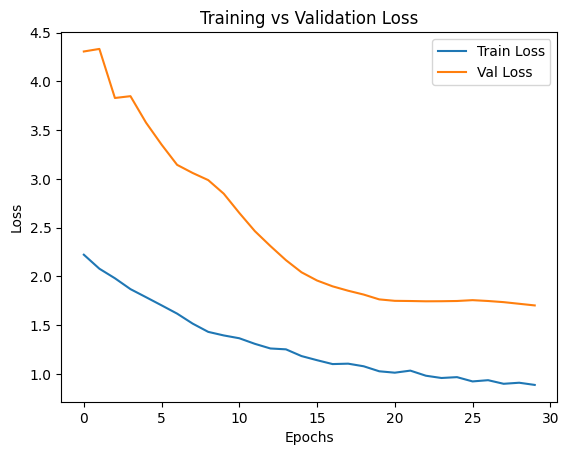

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [28]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 0s - 55ms/step - AUC: 0.5359 - accuracy: 0.2143 - loss: 1.7020
Restored model, accuracy: 21.43%


In [29]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to get binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

print("CNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))

print(classification_report(y_test, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
CNN:
Accuracy: 0.14285714285714285
Precision: 0.3055555555555555
Recall: 0.48148148148148145
F1 Score: 0.3111111111111111
              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         6
        leak       0.25      1.00      0.40         3
       limit       0.67      0.44      0.53         9

   micro avg       0.37      0.39      0.38        18
   macro avg       0.31      0.48      0.31        18
weighted avg       0.38      0.39      0.33        18
 samples avg       0.29      0.24      0.25        18



## CNN With Autoencoder

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

X_unlabeled = np.concatenate([X_train, X_test], axis=0)
# Input
input_layer = Input(shape=(opcode_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(opcode_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_unlabeled, X_unlabeled, epochs=30, batch_size=64)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 148.7385
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 148.2956
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 147.9968
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 147.8628
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 147.8289
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 147.8234
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 147.8228
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 147.8216
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 147.8207
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 147.8197
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 147.8183
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 147.8171
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 147.8158
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 147.8149
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 147.8147
Epoch 

In [31]:
X_encoded = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_train, test_size=0.2, random_state=42)

In [33]:
def EncodedMLClassifier():
    return Sequential([
        Dense(256, input_dim=128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

classifier = EncodedMLClassifier()

classifier.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

model_file = os.path.join(MODEL_PATH, "encoded_cnn_best_model_on_crpwarner_opcode_n_gram.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1667 - loss: 1.1818

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 1.1818 - val_accuracy: 0.1000 - val_loss: 5.1538 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3333 - loss: 1.0334

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3333 - loss: 1.0334 - val_accuracy: 0.1000 - val_loss: 4.4045 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3611 - loss: 0.9740

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3611 - loss: 0.9740 - val_accuracy: 0.1000 - val_loss: 4.0733 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5278 - loss: 0.8941

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5278 - loss: 0.8941 - val_accuracy: 0.1000 - val_loss: 3.6430 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5556 - loss: 0.8455

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5556 - loss: 0.8455 - val_accuracy: 0.1000 - val_loss: 3.2775 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 0.8658

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5000 - loss: 0.8658 - val_accuracy: 0.1000 - val_loss: 3.0838 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4444 - loss: 0.8709

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4444 - loss: 0.8709 - val_accuracy: 0.1000 - val_loss: 2.8670 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 0.8048

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5000 - loss: 0.8048 - val_accuracy: 0.1000 - val_loss: 2.7871 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5556 - loss: 0.8160

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5556 - loss: 0.8160 - val_accuracy: 0.1000 - val_loss: 2.7528 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4722 - loss: 0.7721

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4722 - loss: 0.7721 - val_accuracy: 0.1000 - val_loss: 2.7040 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5278 - loss: 0.8278

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5278 - loss: 0.8278 - val_accuracy: 0.1000 - val_loss: 2.6127 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4444 - loss: 0.7475

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4444 - loss: 0.7475 - val_accuracy: 0.1000 - val_loss: 2.4597 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5556 - loss: 0.7560

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5556 - loss: 0.7560 - val_accuracy: 0.1000 - val_loss: 2.3080 - learning_rate: 0.0010
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5278 - loss: 0.7466

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5278 - loss: 0.7466 - val_accuracy: 0.1000 - val_loss: 2.2011 - learning_rate: 0.0010
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5278 - loss: 0.7168

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5278 - loss: 0.7168 - val_accuracy: 0.1000 - val_loss: 2.1146 - learning_rate: 0.0010
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4722 - loss: 0.7289

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4722 - loss: 0.7289 - val_accuracy: 0.1000 - val_loss: 2.0739 - learning_rate: 0.0010
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6389 - loss: 0.6966

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6389 - loss: 0.6966 - val_accuracy: 0.1000 - val_loss: 1.9739 - learning_rate: 0.0010
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 0.7294

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5000 - loss: 0.7294 - val_accuracy: 0.1000 - val_loss: 1.9212 - learning_rate: 0.0010
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 0.7162

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5000 - loss: 0.7162 - val_accuracy: 0.1000 - val_loss: 1.8796 - learning_rate: 0.0010
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5278 - loss: 0.6878

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5278 - loss: 0.6878 - val_accuracy: 0.1000 - val_loss: 1.8470 - learning_rate: 0.0010
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4444 - loss: 0.6891

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4444 - loss: 0.6891 - val_accuracy: 0.1000 - val_loss: 1.7998 - learning_rate: 0.0010
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - loss: 0.7051

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5000 - loss: 0.7051 - val_accuracy: 0.1000 - val_loss: 1.7697 - learning_rate: 0.0010
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 0.6999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5833 - loss: 0.6999 - val_accuracy: 0.1000 - val_loss: 1.7153 - learning_rate: 0.0010
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 0.6910

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5000 - loss: 0.6910 - val_accuracy: 0.1000 - val_loss: 1.6635 - learning_rate: 0.0010
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5556 - loss: 0.6692

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5556 - loss: 0.6692 - val_accuracy: 0.1000 - val_loss: 1.6243 - learning_rate: 0.0010
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5278 - loss: 0.6907

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5278 - loss: 0.6907 - val_accuracy: 0.1000 - val_loss: 1.5659 - learning_rate: 0.0010
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5000 - loss: 0.6803

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5000 - loss: 0.6803 - val_accuracy: 0.1000 - val_loss: 1.5073 - learning_rate: 0.0010
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5833 - loss: 0.6389

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5833 - loss: 0.6389 - val_accuracy: 0.1000 - val_loss: 1.4759 - learning_rate: 0.0010
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5278 - loss: 0.6954

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5278 - loss: 0.6954 - val_accuracy: 0.1000 - val_loss: 1.4419 - learning_rate: 0.0010
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5278 - loss: 0.6378

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5278 - loss: 0.6378 - val_accuracy: 0.1000 - val_loss: 1.4228 - learning_rate: 0.0010


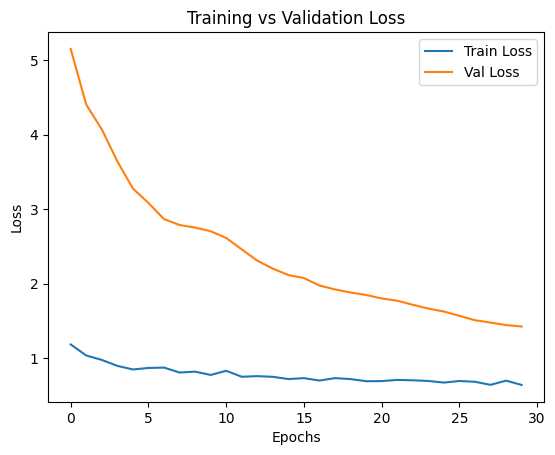

In [34]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [35]:
y_pred_prob = classifier.predict(X_val)
y_pred = (y_pred_prob >= 0.05).astype(int)

print(classification_report(y_val, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
              precision    recall  f1-score   support

        mint       0.20      1.00      0.33         2
        leak       0.20      1.00      0.33         2
       limit       0.11      1.00      0.20         1

   micro avg       0.17      1.00      0.29         5
   macro avg       0.17      1.00      0.29         5
weighted avg       0.18      1.00      0.31         5
 samples avg       0.17      0.40      0.23         5

